In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("tensorflow version", tf.__version__)

tensorflow version 2.16.1


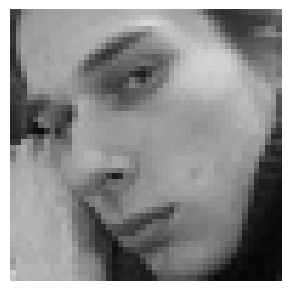

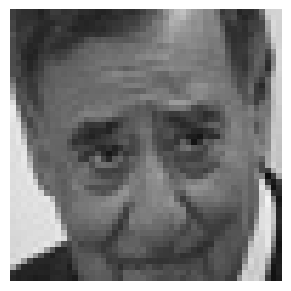

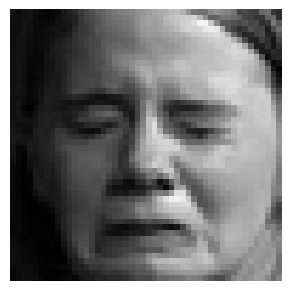

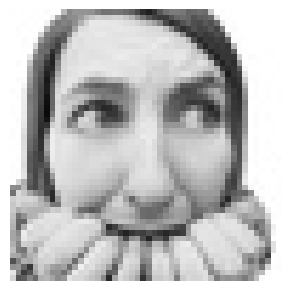

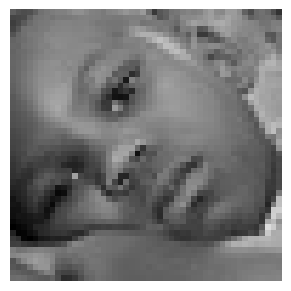

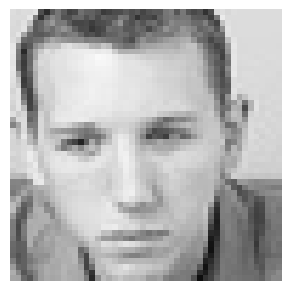

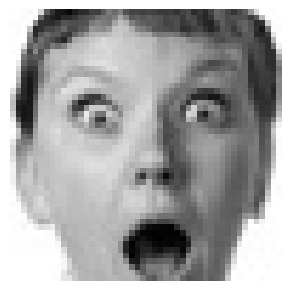

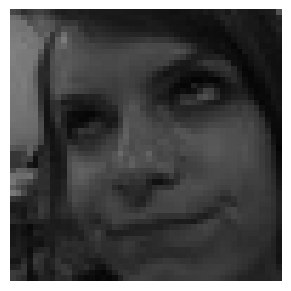

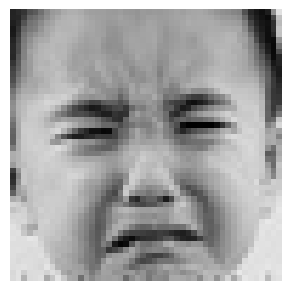

In [2]:
images=glob("train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis("off")

In [3]:
img_size= 48
batch_size= 64
datagen_train= ImageDataGenerator()
train_generator= datagen_train.flow_from_directory("train/",
                                                  target_size= (img_size,img_size),
                                                  color_mode="grayscale",
                                                  batch_size= batch_size,
                                                  class_mode= "categorical",
                                                  shuffle= True)
datagen_validation= ImageDataGenerator()
validation_generator= datagen_validation.flow_from_directory("test/",
                                                  target_size= (img_size,img_size),
                                                  color_mode="grayscale",
                                                  batch_size= batch_size,
                                                  class_mode= "categorical",
                                                  shuffle= True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
def Convolution(input_tensors, filters, kernel_size):
     x= Conv2D(filters= filters, kernel_size= kernel_size ,padding= "same")(input_tensors)
     x= BatchNormalization()(x)
     x= Activation('relu')(x)
     x= MaxPooling2D(pool_size =(2,2))(x)
     x= Dropout(0.25)(x)

     return x

In [5]:
def Dense_f(input_tensor, nodes):
     x= Dense(nodes)(input_tensor)
     x= BatchNormalization()(x)
     x= Activation('relu')(x)
     x= Dropout(0.25)(x)

     return x

In [6]:
def model_fer(input_shape):
    inputs= Input(input_shape)
    conv_1= Convolution(inputs,32,(3,3))
    conv_2 =Convolution(inputs,64,(5,5))
    conv_3= Convolution(inputs,128,(3,3))

    flatten= Flatten()(conv_3)
    dense_1=Dense_f(flatten,256)

    output= Dense(7,activation="softmax")(dense_1)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss= ['categorical_crossentropy'], optimizer='adam', metrics =['accuracy'])
    return model

In [7]:
model =model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
epochs= 15
steps_per_epoch= train_generator.n//train_generator.batch_size
validation_steps= validation_generator.n//validation_generator.batch_size
checkpoint= ModelCheckpoint("model_weights.weights.h5", monitor= 'val accuracy', save_weights_only= True, mode='max', verbose=1)
callbacks=[checkpoint]

In [11]:
history= model.fit(x= train_generator,
                   steps_per_epoch= steps_per_epoch,
                  epochs= epochs,
                  validation_data= validation_generator,
                  validation_steps= validation_steps,
                  callbacks=callbacks)

Epoch 1/15


C:\Users\sahil yadav\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.3216 - loss: 1.8798
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 249s 549ms/step - accuracy: 0.3217 - loss: 1.8793 - val_accuracy: 0.3616 - val_loss: 1.6253
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:13 299ms/step - accuracy: 0.5000 - loss: 1.3038
Epoch 2: saving model to model_weights.weights.h5


C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.5000 - loss: 1.3038 - val_accuracy: 0.2000 - val_loss: 1.7703
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4796 - loss: 1.3672
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 140s 313ms/step - accuracy: 0.4796 - loss: 1.3672 - val_accuracy: 0.3620 - val_loss: 1.5861
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:15 304ms/step - accuracy: 0.5312 - loss: 1.3576
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - accuracy: 0.5312 - loss: 1.3576 - val_accuracy: 0.4000 - val_loss: 1.1862
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5566 - loss: 1.1806
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 140s 313ms/step - accuracy: 0.5566 - loss: 1.1807 - val_accuracy: 0.4301 - val_loss: 1.4777
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:15 303ms/step - accuracy: 0.4688 - loss: 1.2831
Epoch 6: savin

In [12]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4818 - loss: 1.5618


[1.5444296598434448, 0.49066591262817383]

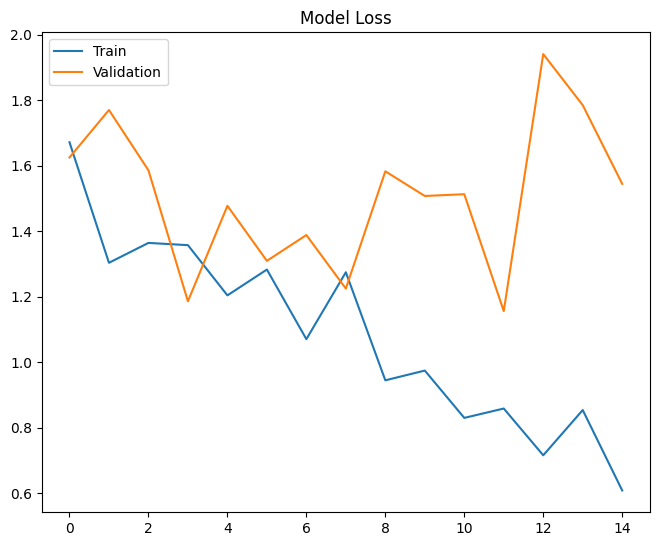

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

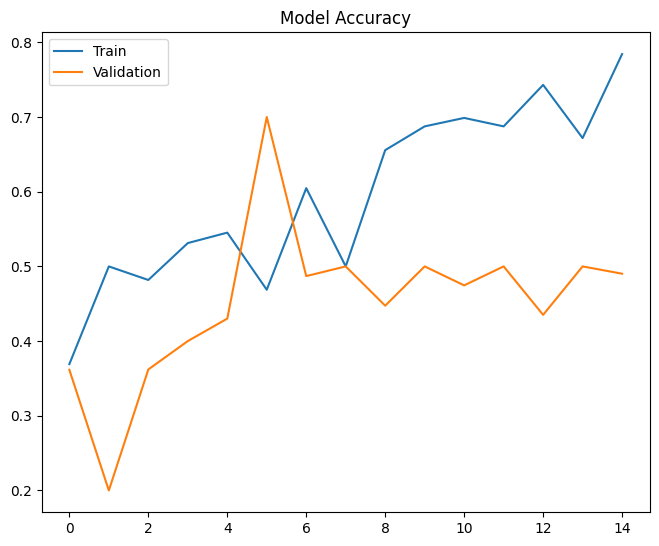

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [16]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)